In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm

Load all data

In [29]:
def load_news(news_path):
    df = pd.read_csv(news_path, sep='\t', header=None,
                     names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
    df['content'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')
    return df[['news_id', 'content']]

train_news = load_news('MINDsmall_train/news.tsv')
dev_news = load_news('MINDsmall_dev/news.tsv')
# Check for duplicates on news_id and content
all_news = pd.concat([train_news, dev_news]).drop_duplicates(['news_id', 'content'])

In [30]:
all_news.head()

,news_id,content
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an..."
1,N19639,50 Worst Habits For Belly Fat These seemingly ...
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...
3,N53526,I Was An NBA Wife. Here's How It Affected My M...
4,N38324,"How to Get Rid of Skin Tags, According to a De..."


In [31]:
all_news.loc[0].content

"The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By Shop the notebooks, jackets, and more that the royals can't live without."

In [32]:
all_news.describe()

,news_id,content
count,65238,65238
unique,65238,64277
top,N39563,Photos of the Day Our top photos from the last...
freq,1,15


In [33]:
print("Size of the train dataset:", train_news.shape[0])
print("Size of the test dataset:", dev_news.shape[0])

Size of the train dataset: 51282
Size of the test dataset: 42416


train TF-IDF

In [34]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
news_vectors = vectorizer.fit_transform(train_news['content'])  # only train content for training

# Map news_id to index
news_id_to_index = dict(zip(train_news['news_id'], range(len(train_news))))

Calculate embeddings

In [35]:
# Load the embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
# Compute embeddings for all text rows
embeddings = model.encode(train_news['content'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 1603/1603 [00:34<00:00, 46.27it/s]


Load Training Behaviors and Build User Profiles

In [36]:
train_behaviors = pd.read_csv('MINDsmall_train/behaviors.tsv', sep='\t', header=None,
                              names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

user_profiles = {}

for _, row in train_behaviors.iterrows():
    user = row['user_id']
    history = row['history']
    if pd.isna(history): continue
    history_ids = [nid for nid in history.split() if nid in news_id_to_index]
    if not history_ids: continue
    indices = [news_id_to_index[nid] for nid in history_ids]
    profile_vector = news_vectors[indices].mean(axis=0)
    user_profiles[user] = profile_vector

In [37]:
user_embed_profiles = {}

for _, row in train_behaviors.iterrows():
    user = row['user_id']
    history = row['history']
    if pd.isna(history): continue
    history_ids = [nid for nid in history.split() if nid in news_id_to_index]
    if not history_ids: continue
    indices = [news_id_to_index[nid] for nid in history_ids]
    user_embedding = np.mean([embeddings[i] for i in indices], axis=0)
    user_embed_profiles[user] = user_embedding.reshape(1, -1)  # Reshape to 2D array for cosine similarity

Evaluate the model on the dev set

In [38]:
dev_behaviors = pd.read_csv('MINDsmall_dev/behaviors.tsv', sep='\t', header=None,
                            names=['impression_id', 'user_id', 'time', 'history', 'impressions'])


def mrr(scores, labels):
    sorted_labels = [l for _, l in sorted(zip(scores, labels), reverse=True)]
    for i, label in enumerate(sorted_labels):
        if label == 1:
            return 1.0 / (i + 1)
    return 0.0

def ndcg(scores, labels, k):
    sorted_labels = [l for _, l in sorted(zip(scores, labels), reverse=True)][:k]
    dcg = sum([1.0 / np.log2(i + 2) if l == 1 else 0 for i, l in enumerate(sorted_labels)])
    ideal_dcg = sum([1.0 / np.log2(i + 2) for i in range(min(sum(labels), k))])
    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0

def evaluate(dev_behaviors, news_id_to_index, news_vectors, user_profiles):
    aucs, mrrs, ndcg5s, ndcg10s = [], [], [], []

    for _, row in tqdm(dev_behaviors.iterrows(), total=len(dev_behaviors)):
        user = row['user_id']
        impressions = [imp.split('-') for imp in row['impressions'].split()]
        news_ids = [nid for nid, _ in impressions if nid in news_id_to_index]
        labels = [int(label) for nid, label in impressions if nid in news_id_to_index]

        if not news_ids or user not in user_profiles or len(set(labels)) == 1:
            continue

        profile_vector = np.asarray(user_profiles[user])  # Convert to numpy array
        candidate_idxs = [news_id_to_index[nid] for nid in news_ids]
        candidate_vectors = news_vectors[candidate_idxs]
        # print(f"Candidate vectors shape: {candidate_vectors.shape}")
        # print(f"Profile vector shape: {profile_vector.shape}")
        sims = cosine_similarity(profile_vector, candidate_vectors).flatten()

        aucs.append(roc_auc_score(labels, sims, multi_class='ovr'))
        mrrs.append(mrr(sims, labels))
        ndcg5s.append(ndcg(sims, labels, 5))
        ndcg10s.append(ndcg(sims, labels, 10))

    return {
        'AUC': np.mean(aucs),
        'MRR': np.mean(mrrs),
        'nDCG@5': np.mean(ndcg5s),
        'nDCG@10': np.mean(ndcg10s)
    }

Evaluate a baseline system (random reccomender)

In [39]:
def evaluate_random(dev_behaviors, news_id_to_index):
    aucs, mrrs, ndcg5s, ndcg10s = [], [], [], []

    for _, row in tqdm(dev_behaviors.iterrows(), total=len(dev_behaviors)):
        impressions = [imp.split('-') for imp in row['impressions'].split()]
        news_ids = [nid for nid, _ in impressions if nid in news_id_to_index]
        labels = [int(label) for nid, label in impressions if nid in news_id_to_index]

        if not news_ids or len(set(labels)) == 1:
            continue

        random_scores = [random.random() for _ in labels]

        aucs.append(roc_auc_score(labels, random_scores))
        mrrs.append(mrr(random_scores, labels))
        ndcg5s.append(ndcg(random_scores, labels, 5))
        ndcg10s.append(ndcg(random_scores, labels, 10))

    return {
        'AUC': np.mean(aucs),
        'MRR': np.mean(mrrs),
        'nDCG@5': np.mean(ndcg5s),
        'nDCG@10': np.mean(ndcg10s)
    }

Compare results

In [40]:
cb_results = evaluate(dev_behaviors, news_id_to_index, news_vectors, user_profiles)
rand_results = evaluate_random(dev_behaviors, news_id_to_index)
embed_results = evaluate(dev_behaviors, news_id_to_index, embeddings, user_embed_profiles)

# Display comparison
print("Content-Based Recommender Performance:")
for metric, score in cb_results.items():
    print(f"{metric}: {score:.4f}")

print("\nContent-Based Embedding Recommender Performance:")
for metric, score in embed_results.items():
    print(f"{metric}: {score:.4f}")

print("\nRandom Recommender Performance:")
for metric, score in rand_results.items():
    print(f"{metric}: {score:.4f}")

100%|██████████| 73152/73152 [00:17<00:00, 4213.56it/s]

Content-Based Recommender Performance:
AUC: 0.5737
MRR: 0.3466
nDCG@5: 0.3341
nDCG@10: 0.3948

Content-Based Embedding Recommender Performance:
AUC: 0.6415
MRR: 0.3738
nDCG@5: 0.3637
nDCG@10: 0.4205

Random Recommender Performance:
AUC: 0.4993
MRR: 0.2597
nDCG@5: 0.2438
nDCG@10: 0.3072


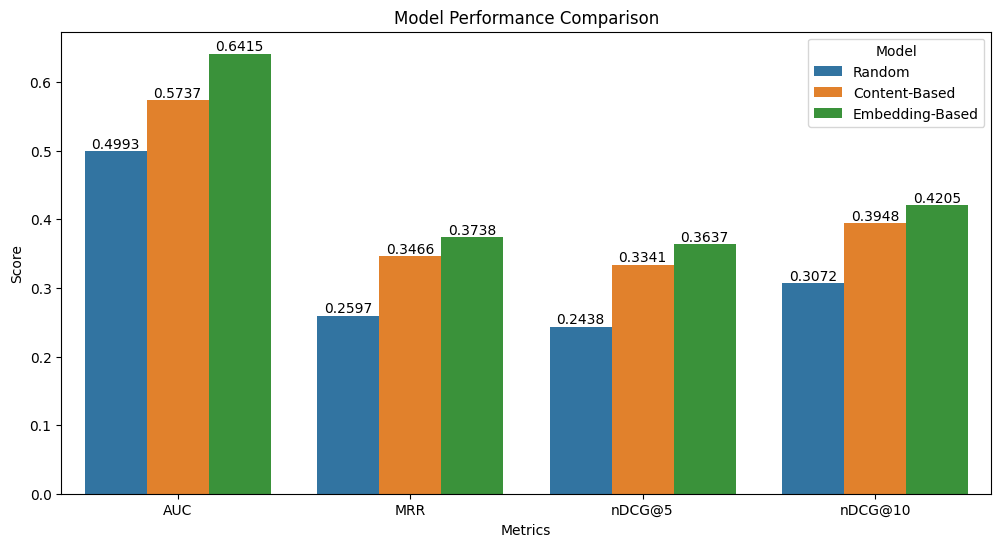

In [41]:
# Combine results into a single dictionary for easy plotting
all_results = {
    "Random": rand_results,
    "Content-Based": cb_results,
    "Embedding-Based": embed_results    
}

# Round the results to 4 decimal places
for model, metrics in all_results.items():
    for metric, score in metrics.items():
        all_results[model][metric] = round(score, 4)

# Convert the results into a DataFrame for easier plotting
results_df = pd.DataFrame(all_results).T
results_df.reset_index(inplace=True)
results_df.columns = ['Model', 'AUC', 'MRR', 'nDCG@5', 'nDCG@10']
results_df = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
# Set the figure size
plt.figure(figsize=(12, 6))
# Create a bar plot
ax = sns.barplot(x='Metric', y='Score', hue='Model', data=results_df)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
# Set the title and labels
plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
# Show the plot
plt.legend(title='Model')
plt.show()